In [1]:
# Importaciones
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))  # Nombre de tu GPU

True
1
NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
print(dir(torch))  # Debe incluir '_utils' en la lista

['AVG', 'AggregationType', 'AliasDb', 'AnyType', 'Argument', 'ArgumentSpec', 'AwaitType', 'BFloat16Storage', 'BFloat16Tensor', 'BenchmarkConfig', 'BenchmarkExecutionStats', 'Block', 'BoolStorage', 'BoolTensor', 'BoolType', 'BufferDict', 'ByteStorage', 'ByteTensor', 'CallStack', 'Capsule', 'CharStorage', 'CharTensor', 'ClassType', 'Code', 'CompilationUnit', 'CompleteArgumentSpec', 'ComplexDoubleStorage', 'ComplexFloatStorage', 'ComplexType', 'ConcreteModuleType', 'ConcreteModuleTypeBuilder', 'DeepCopyMemoTable', 'DeserializationStorageContext', 'DeviceObjType', 'DictType', 'DisableTorchFunction', 'DisableTorchFunctionSubclass', 'DispatchKey', 'DispatchKeySet', 'DoubleStorage', 'DoubleTensor', 'EnumType', 'ErrorReport', 'Event', 'ExcludeDispatchKeyGuard', 'ExecutionPlan', 'FatalError', 'FileCheck', 'FloatStorage', 'FloatTensor', 'FloatType', 'FunctionSchema', 'Future', 'FutureType', 'Generator', 'GradScaler', 'Gradient', 'Graph', 'GraphExecutorState', 'HalfStorage', 'HalfTensor', 'IODesc

In [4]:
torch.cuda.empty_cache() 

In [5]:
import torch.nn as nn

# ReLU -> ReLU(x)=max(0,x) devuelve el valor x si es mayor que 0, de lo contrario devuelve 0
# BatchNorm -> Normaliza la salida de la capa anterior, manteniendo la media y varianza

class FruitMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(), # Aplana la imagen de entrada

            # capa de entrada -> primera capa oculta
            nn.Linear(100*100*3, 512),  # Capa amplia para fondos variables
            nn.BatchNorm1d(512), # Normalizaci√≥n para estabilizar la red, a una dimension
            nn.ReLU(),
            nn.Dropout(0.5), # Dropout para evitar sobreajuste
            
            # primera capa oculta -> segunda capa oculta
            nn.Linear(512, 128), # Refinamiento de caracter√≠sticas
            nn.BatchNorm1d(128), # Normalizaci√≥n para estabilizar la red, a una dimension
            nn.ReLU(),
            
            # segunda capa oculta -> capa de salida
            nn.Linear(128, 169) # Salida (169 frutas)
        )
    
    def forward(self, x):
        # x es la imagen de entrada
        return self.layers(x)

In [6]:
# 2. Instanciar el modelo
model = FruitMLP()
print("Modelo creado!")

Modelo creado!


In [7]:
# 3. Verificar GPU y mover el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo seleccionado: {device}")

# limpiar_memoria()  # Libera memoria de la GPU antes de mover el modelo
model = model.to(device)  # Mueve el modelo a GPU/CPU
print("¬°Modelo enviado a", device, "!")

Dispositivo seleccionado: cuda
¬°Modelo enviado a cuda !


In [8]:
# Transformaci√≥n TEMPORAL para c√°lculo (sin normalizaci√≥n)
temp_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])
# Cargar el conjunto de datos de entrenamiento en la GPU
train_dataset_temp = datasets.ImageFolder(
    root='C:/Users/OMEN/Documents/7mo Semestre-01-2025/Inteligencia Artificial/Lab-002/fruits-360/Training',
    transform=temp_transform
)

train_loader_temp = torch.utils.data.DataLoader( # dataLolder -> es un objeto iterable
    train_dataset_temp,
    batch_size=64,  # Tama√±o del lote
    shuffle=False,   # Barajar los datos en False
)
# C√°lculo de la media y desviaci√≥n est√°ndar
mean = torch.zeros(3).to(device)  # Inicializa el tensor de media
std = torch.zeros(3).to(device)   # Inicializa el tensor de desviaci√≥n est√°ndar
total_pixels = 0  # Inicializa el contador de p√≠xeles

# Iterar sobre el conjunto de datos de entrenamiento
# para calcular la media y desviaci√≥n est√°ndar
# (sin normalizaci√≥n)
for images, _ in train_loader_temp:
    images = images.to(device)  # Manda batch a GPU
    batch_pixels = images.size(0) * images.size(2) * images.size(3)  # batch * altura * ancho
    images = images.view(images.size(0), 3, -1)  # [batch, canales, pixels]
    
    mean += images.mean(2).sum(0)  # Suma medias por canal
    std += images.std(2).sum(0)    # Suma std por canal
    total_pixels += batch_pixels

mean /= len(train_loader_temp.dataset)
std /= len(train_loader_temp.dataset)

print("Media (Train):", mean.cpu().tolist()) # media 
print("Std (Train):", std.cpu().tolist()) # desviaci√≥n est√°ndar / standard deviation

Media (Train): [0.6726435422897339, 0.5792443752288818, 0.508468508720398]
Std (Train): [0.26989850401878357, 0.32609033584594727, 0.3682645261287689]


In [15]:
indice = 4000  # Cambia este n√∫mero al que desees

# Obtener la imagen espec√≠fica
imagen, etiqueta = train_dataset_temp[indice]
print(f"clase:{train_dataset_temp.classes[etiqueta]}")

# Imprimir el tensor
print(f"Tensor de la imagen en el √≠ndice {indice}:")
print(imagen)

clase:Apple 6
Tensor de la imagen en el √≠ndice 4000:
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
    

In [17]:
imagen , etiqueta= train_dataset_temp[300]
print(f"clase:{train_dataset_temp.classes[etiqueta]}")
print(imagen)

clase:Apple 10
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0

In [24]:
# valores calculados
#Media = [0.6726, 0.5792, 0.5084]
#Std = [0.2698, 0.3260, 0.3683]

Media = [0.6726435422897339, 0.5792443752288818, 0.508468508720398]
Std = [0.26989850401878357, 0.32609033584594727, 0.3682645261287689]

# Normalizaci√≥n de los datos
train_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(10),
    #transforms.ColorJitter(brightness=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=Media, std=Std)  # Normalizaci√≥n cr√≠tica
])

# Transformaci√≥n para el conjunto de test
test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=Media, std=Std)  # Normalizaci√≥n cr√≠tica
])

# Cargar el conjunto de datos de entrenamiento y Test
train_dataset = datasets.ImageFolder( # el ImageFolder es un objeto iterable
    # Cargar el conjunto de datos de entrenamiento
    root= "C:/Users/OMEN/Documents/7mo Semestre-01-2025/Inteligencia Artificial/Lab-002/fruits-360/Training",
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root="C:/Users/OMEN/Documents/7mo Semestre-01-2025/Inteligencia Artificial/Lab-002/fruits-360/Test",
    transform=test_transform
)

# Creamos DataLoader para cargar los datos / que es el dataLoader -> 
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,          # Batch grande para estabilidad
    shuffle=True,            # Mezcla para entrenamiento
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True,           # No mezclar en test
)

# Verificaci√≥n
print(f"Clases: {len(train_dataset.classes)}")  # Debe mostrar 169
print(f"Im√°genes en entrenamiento: {len(train_dataset)}")
print(f"Im√°genes en test: {len(test_dataset)}")

print(f"Clases: {train_dataset.classes}")  # Debe mostrar 169
print("indice de clases:", train_dataset.class_to_idx)  # Muestra el √≠ndice de clases

print(f"clases de test: {test_dataset.classes}")  # Debe mostrar 170
print("indice de clases:", test_dataset.class_to_idx)  # Muestra el √≠ndice de clases

Clases: 169
Im√°genes en entrenamiento: 86308
Im√°genes en test: 28863
Clases: ['Apple 10', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 19', 'Apple 6', 'Apple 9', 'Apple Braeburn 1', 'Apple Core 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple Rotten 1', 'Apple hit 1', 'Apple worm 1', 'Apricot 1', 'Avocado 1', 'Avocado ripe 1', 'Banana 1', 'Banana 3', 'Banana Lady Finger 1', 'Banana Red 1', 'Beans 1', 'Beetroot 1', 'Blackberrie 1', 'Blackberrie 2', 'Blackberrie half rippen 1', 'Blackberrie not rippen 1', 'Blueberry 1', 'Cabbage red 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cactus fruit green 1', 'Cactus fruit red 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 'Cauliflower 1', 'Cherimoya 1', 'Cherry 1', 'Cherry 2', 'Cherry Rainier 1', 'Cherry Wax Black 1', 'Cherry 

El DataLoader en PyTorch es una utilidad fundamental que se encarga de cargar, organizar y procesar tus datos de manera eficiente durante el entrenamiento de tu red neuronal.

Etiqueta: Pistachio 1


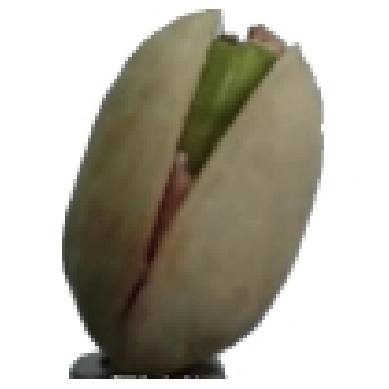

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))  # Convertir a HWC
    img = img * std.cpu().numpy() + mean.cpu().numpy()  # Desnormalizar
    img = np.clip(img, 0, 1)                     # Asegurar rango [0,1]
    plt.imshow(img)
    plt.axis('off')

# Mostrar primera imagen del batch
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(images[0])
print(f"Etiqueta: {train_dataset.classes[labels[0]]}")

Etiqueta: Pear 2


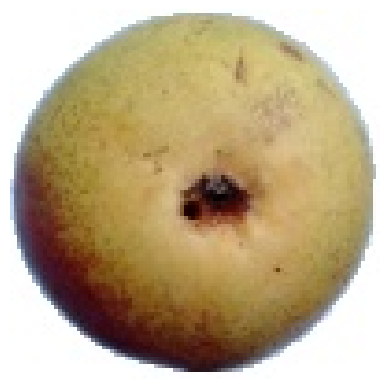

In [26]:
# Mostrar primera imagen del batch
dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(images[0])
print(f"Etiqueta: {train_dataset.classes[labels[0]]}")

In [42]:
for images, labels in test_loader:
    print("labels en entrenamiento", labels)
    break

labels en entrenamiento tensor([129, 122,  25, 106, 102, 127, 159, 132,  30, 122,  77,  85,  37,  79,
         68, 125,   1, 109,  61,  85,   5, 124, 168, 110, 127,  71,  31, 145,
         48,  46, 127,  55])


1. Optimizador: SGD (Descenso de Gradiente Estoc√°stico)
Explicaci√≥n breve para el curso:
El SGD (Stochastic Gradient Descent) es uno de los optimizadores m√°s b√°sicos en Deep Learning. Su funci√≥n es ajustar los pesos de la red neuronal mediante el c√°lculo del gradiente (derivada) de la funci√≥n de p√©rdida.

Ventajas:

Simple y f√°cil de entender.

Funciona bien en muchos problemas cl√°sicos.

Permfine ajustar manualmente la tasa de aprendizaje (learning rate).

Hiperpar√°metros clave:

lr (Learning Rate): Controla el tama√±o de los pasos en la actualizaci√≥n de los pesos (demasiado alto ‚Üí inestabilidad; demasiado bajo ‚Üí lento).

momentum (opcional): Ayuda a evitar m√≠nimos locales y acelera la convergencia.

2. Funci√≥n de P√©rdida (Loss Function)
La m√°s b√°sica y necesaria: CrossEntropyLoss

¬øQu√© hace?

Mide qu√© tan lejos est√°n las predicciones de la red (logits) de las etiquetas reales.

Combina LogSoftmax + NLLLoss (Negative Log Likelihood Loss) en una sola funci√≥n.

Ideal para problemas de clasificaci√≥n multiclase (como tu caso con 170 clases).



In [ ]:
# Optimizador (SGD)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.95, weight_decay=1e-5) 
#optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# el weight decay es la regularizaci√≥n L2 osea la penalizaci√≥n de los pesos
# SGD -> Stochastic Gradient Descent (descenso de gradiente estoc√°stico)

# Funci√≥n de p√©rdida
criterion = nn.CrossEntropyLoss()

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
# Scheduler para reducir la tasa de aprendizaje si el rendimiento no mejora
# (patience=2 significa esperar 2 √©pocas antes de reducir la tasa de aprendizaje)
# Scheduler para reducir la tasa de aprendizaje
# (scheduler) -> ReduceLROnPlateau reduce la tasa de aprendizaje si la m√©trica no mejora
# (mode='min') -> se usa para problemas de regresi√≥n 
# (patience=2) -> n√∫mero de √©pocas sin mejora antes de reducir la tasa

print("¬°Optimizador y funci√≥n de p√©rdida creados!")
print("optimizador", optimizer)
print("funci√≥n de p√©rdida", criterion)
#print("Scheduler", scheduler)

¬°Optimizador y funci√≥n de p√©rdida creados!
optimizador SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 5e-05
    maximize: False
    momentum: 0.95
    nesterov: False
    weight_decay: 1e-05
)
funci√≥n de p√©rdida CrossEntropyLoss()


# funcion dde entrenamiento

In [44]:
def entrenar_epoca(modelo, cargador, optimizador, criterio, dispositivo):
    modelo.train()
    perdida_total = 0.0
    correctas = 0
    total = 0
    
    with tqdm(cargador, unit="batch", desc="Entrenamiento") as barra:
        for imagenes, etiquetas in barra:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            
            optimizador.zero_grad()
            salidas = modelo(imagenes)
            perdida = criterio(salidas, etiquetas)
            perdida.backward()
            optimizador.step()
            
            perdida_total += perdida.item()
            _, predichas = torch.max(salidas, 1)
            correctas += (predichas == etiquetas).sum().item()
            total += etiquetas.size(0)
            
            barra.set_postfix(
                perdida=perdida.item(),
                precision=f"{100 * correctas / total:.2f}%"
            )
    
    # calcular el porcentaje de error
    error = 100 * (1 - correctas / total)
    return perdida_total / len(cargador), 100 * correctas / total, error

# funcion de validacion

In [46]:
def evaluar(modelo, cargador, criterio, dispositivo):
    modelo.eval()  # Modo evaluaci√≥n
    perdida_total = 0.0
    correctas = 0
    total = 0

    with torch.no_grad():  # Desactiva gradientes
        for imagenes, etiquetas in tqdm(cargador, desc="Prueba"):
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            salidas = modelo(imagenes)
            perdida = criterio(salidas, etiquetas)
            
            # M√©tricas
            perdida_total += perdida.item()
            _, predichas = torch.max(salidas, 1)
            correctas += (predichas == etiquetas).sum().item()
            total += etiquetas.size(0)

    error_porcentaje = (1 - correctas / total) * 100
    
    return perdida_total / len(cargador), 100 * correctas / total, error_porcentaje

In [47]:
def graficar_resultados(perdidas_ent, precision_ent, perdidas_test, precision_test):
    plt.figure(figsize=(12, 5))
    
    # Gr√°fica de p√©rdida
    plt.subplot(1, 2, 1)
    plt.plot(perdidas_ent, label='Entrenamiento')
    plt.plot(perdidas_test, label='Prueba')
    plt.title('P√©rdida por √âpoca')
    plt.xlabel('√âpoca')
    plt.ylabel('P√©rdida')
    plt.legend()
    
    # Gr√°fica de precisi√≥n
    plt.subplot(1, 2, 2)
    plt.plot(precision_ent, label='Entrenamiento')
    plt.plot(precision_test, label='Prueba')
    plt.title('Precisi√≥n por √âpoca')
    plt.xlabel('√âpoca')
    plt.ylabel('Precisi√≥n (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# --- 5. Bucle de Entrenamiento ---

VRAM usada: 58.94 MB

√âpoca 1/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [02:56<00:00,  5.11it/s]



Resumen √âpoca 1:
  P√©rdida: Train = 4.2702 | Test = 3.8742
  Precisi√≥n: Train = 30.35% | Test = 53.01%
  Error: entrenamiento: 69.6540% | error test: 46.9944%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 2/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.33it/s]



Resumen √âpoca 2:
  P√©rdida: Train = 3.5732 | Test = 3.4273
  Precisi√≥n: Train = 55.31% | Test = 61.27%
  Error: entrenamiento: 44.6923% | error test: 38.7278%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 3/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.81it/s]



Resumen √âpoca 3:
  P√©rdida: Train = 3.0627 | Test = 2.9363
  Precisi√≥n: Train = 64.74% | Test = 65.36%
  Error: entrenamiento: 35.2609% | error test: 34.6395%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 4/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.27it/s]



Resumen √âpoca 4:
  P√©rdida: Train = 2.6031 | Test = 2.5003
  Precisi√≥n: Train = 71.10% | Test = 69.87%
  Error: entrenamiento: 28.8988% | error test: 30.1285%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 5/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.31it/s]



Resumen √âpoca 5:
  P√©rdida: Train = 2.1900 | Test = 2.1535
  Precisi√≥n: Train = 76.80% | Test = 74.47%
  Error: entrenamiento: 23.2018% | error test: 25.5344%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 6/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.54it/s]



Resumen √âpoca 6:
  P√©rdida: Train = 1.8295 | Test = 1.8855
  Precisi√≥n: Train = 81.97% | Test = 77.47%
  Error: entrenamiento: 18.0342% | error test: 22.5271%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 7/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.22it/s]



Resumen √âpoca 7:
  P√©rdida: Train = 1.5209 | Test = 1.6252
  Precisi√≥n: Train = 86.20% | Test = 80.34%
  Error: entrenamiento: 13.8041% | error test: 19.6584%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 8/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.68it/s]



Resumen √âpoca 8:
  P√©rdida: Train = 1.2704 | Test = 1.4344
  Precisi√≥n: Train = 89.23% | Test = 82.37%
  Error: entrenamiento: 10.7684% | error test: 17.6281%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 9/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.36it/s]



Resumen √âpoca 9:
  P√©rdida: Train = 1.0588 | Test = 1.2299
  Precisi√≥n: Train = 91.70% | Test = 83.61%
  Error: entrenamiento: 8.3040% | error test: 16.3947%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 10/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.75it/s]



Resumen √âpoca 10:
  P√©rdida: Train = 0.8893 | Test = 1.1160
  Precisi√≥n: Train = 93.43% | Test = 84.41%
  Error: entrenamiento: 6.5718% | error test: 15.5909%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 11/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:22<00:00, 40.31it/s]



Resumen √âpoca 11:
  P√©rdida: Train = 0.7494 | Test = 0.9999
  Precisi√≥n: Train = 94.60% | Test = 85.75%
  Error: entrenamiento: 5.3981% | error test: 14.2501%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 12/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.63it/s]



Resumen √âpoca 12:
  P√©rdida: Train = 0.6427 | Test = 0.9381
  Precisi√≥n: Train = 95.59% | Test = 86.28%
  Error: entrenamiento: 4.4109% | error test: 13.7235%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 13/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.23it/s]



Resumen √âpoca 13:
  P√©rdida: Train = 0.5506 | Test = 0.8286
  Precisi√≥n: Train = 96.41% | Test = 87.22%
  Error: entrenamiento: 3.5883% | error test: 12.7811%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 14/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.61it/s]



Resumen √âpoca 14:
  P√©rdida: Train = 0.4836 | Test = 0.7833
  Precisi√≥n: Train = 96.94% | Test = 87.21%
  Error: entrenamiento: 3.0577% | error test: 12.7880%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 15/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.60it/s]



Resumen √âpoca 15:
  P√©rdida: Train = 0.4254 | Test = 0.7195
  Precisi√≥n: Train = 97.49% | Test = 87.60%
  Error: entrenamiento: 2.5061% | error test: 12.4000%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 16/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.62it/s]



Resumen √âpoca 16:
  P√©rdida: Train = 0.3740 | Test = 0.7052
  Precisi√≥n: Train = 97.85% | Test = 87.77%
  Error: entrenamiento: 2.1493% | error test: 12.2267%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 17/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.80it/s]



Resumen √âpoca 17:
  P√©rdida: Train = 0.3356 | Test = 0.6622
  Precisi√≥n: Train = 98.16% | Test = 88.12%
  Error: entrenamiento: 1.8388% | error test: 11.8837%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 18/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.36it/s]



Resumen √âpoca 18:
  P√©rdida: Train = 0.3044 | Test = 0.6340
  Precisi√≥n: Train = 98.34% | Test = 88.64%
  Error: entrenamiento: 1.6569% | error test: 11.3640%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 19/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.82it/s]



Resumen √âpoca 19:
  P√©rdida: Train = 0.2720 | Test = 0.6144
  Precisi√≥n: Train = 98.62% | Test = 88.90%
  Error: entrenamiento: 1.3846% | error test: 11.1007%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 20/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.74it/s]



Resumen √âpoca 20:
  P√©rdida: Train = 0.2477 | Test = 0.5873
  Precisi√≥n: Train = 98.80% | Test = 89.49%
  Error: entrenamiento: 1.1992% | error test: 10.5083%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 21/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.49it/s]



Resumen √âpoca 21:
  P√©rdida: Train = 0.2294 | Test = 0.5691
  Precisi√≥n: Train = 98.98% | Test = 89.55%
  Error: entrenamiento: 1.0196% | error test: 10.4494%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 22/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:21<00:00, 42.80it/s]



Resumen √âpoca 22:
  P√©rdida: Train = 0.2110 | Test = 0.5645
  Precisi√≥n: Train = 99.06% | Test = 89.64%
  Error: entrenamiento: 0.9373% | error test: 10.3593%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 23/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.12it/s]



Resumen √âpoca 23:
  P√©rdida: Train = 0.1898 | Test = 0.5472
  Precisi√≥n: Train = 99.26% | Test = 89.51%
  Error: entrenamiento: 0.7415% | error test: 10.4875%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 24/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.86it/s]



Resumen √âpoca 24:
  P√©rdida: Train = 0.1786 | Test = 0.5249
  Precisi√≥n: Train = 99.25% | Test = 89.86%
  Error: entrenamiento: 0.7543% | error test: 10.1445%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 25/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.41it/s]



Resumen √âpoca 25:
  P√©rdida: Train = 0.1657 | Test = 0.5222
  Precisi√≥n: Train = 99.37% | Test = 89.86%
  Error: entrenamiento: 0.6315% | error test: 10.1445%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 26/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:21<00:00, 42.80it/s]



Resumen √âpoca 26:
  P√©rdida: Train = 0.1555 | Test = 0.5041
  Precisi√≥n: Train = 99.39% | Test = 90.00%
  Error: entrenamiento: 0.6118% | error test: 9.9955%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 27/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.61it/s]



Resumen √âpoca 27:
  P√©rdida: Train = 0.1442 | Test = 0.4970
  Precisi√≥n: Train = 99.48% | Test = 90.15%
  Error: entrenamiento: 0.5179% | error test: 9.8534%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 28/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 42.99it/s]



Resumen √âpoca 28:
  P√©rdida: Train = 0.1345 | Test = 0.4827
  Precisi√≥n: Train = 99.55% | Test = 90.57%
  Error: entrenamiento: 0.4461% | error test: 9.4273%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 29/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.69it/s]



Resumen √âpoca 29:
  P√©rdida: Train = 0.1286 | Test = 0.4775
  Precisi√≥n: Train = 99.59% | Test = 90.07%
  Error: entrenamiento: 0.4102% | error test: 9.9297%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 30/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.79it/s]



Resumen √âpoca 30:
  P√©rdida: Train = 0.1241 | Test = 0.4720
  Precisi√≥n: Train = 99.56% | Test = 90.24%
  Error: entrenamiento: 0.4414% | error test: 9.7634%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 31/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 44.04it/s]



Resumen √âpoca 31:
  P√©rdida: Train = 0.1175 | Test = 0.4624
  Precisi√≥n: Train = 99.56% | Test = 90.65%
  Error: entrenamiento: 0.4391% | error test: 9.3476%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 32/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:22<00:00, 40.17it/s]



Resumen √âpoca 32:
  P√©rdida: Train = 0.1107 | Test = 0.4628
  Precisi√≥n: Train = 99.64% | Test = 90.60%
  Error: entrenamiento: 0.3569% | error test: 9.4030%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 33/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.49it/s]



Resumen √âpoca 33:
  P√©rdida: Train = 0.1096 | Test = 0.4505
  Precisi√≥n: Train = 99.58% | Test = 90.70%
  Error: entrenamiento: 0.4160% | error test: 9.2956%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 34/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.46it/s]



Resumen √âpoca 34:
  P√©rdida: Train = 0.0988 | Test = 0.4498
  Precisi√≥n: Train = 99.69% | Test = 90.29%
  Error: entrenamiento: 0.3059% | error test: 9.7149%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 35/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.71it/s]



Resumen √âpoca 35:
  P√©rdida: Train = 0.0954 | Test = 0.4500
  Precisi√≥n: Train = 99.69% | Test = 90.80%
  Error: entrenamiento: 0.3094% | error test: 9.2021%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 36/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.48it/s]



Resumen √âpoca 36:
  P√©rdida: Train = 0.0900 | Test = 0.4389
  Precisi√≥n: Train = 99.73% | Test = 90.78%
  Error: entrenamiento: 0.2734% | error test: 9.2194%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 37/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:22<00:00, 39.29it/s]



Resumen √âpoca 37:
  P√©rdida: Train = 0.0880 | Test = 0.4322
  Precisi√≥n: Train = 99.74% | Test = 90.94%
  Error: entrenamiento: 0.2642% | error test: 9.0635%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 38/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.74it/s]



Resumen √âpoca 38:
  P√©rdida: Train = 0.0834 | Test = 0.4238
  Precisi√≥n: Train = 99.73% | Test = 90.92%
  Error: entrenamiento: 0.2700% | error test: 9.0843%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 39/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.37it/s]



Resumen √âpoca 39:
  P√©rdida: Train = 0.0827 | Test = 0.4187
  Precisi√≥n: Train = 99.74% | Test = 91.20%
  Error: entrenamiento: 0.2595% | error test: 8.7967%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 40/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:20<00:00, 43.83it/s]



Resumen √âpoca 40:
  P√©rdida: Train = 0.0756 | Test = 0.4194
  Precisi√≥n: Train = 99.78% | Test = 90.85%
  Error: entrenamiento: 0.2225% | error test: 9.1501%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 41/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:21<00:00, 42.95it/s]



Resumen √âpoca 41:
  P√©rdida: Train = 0.0780 | Test = 0.4190
  Precisi√≥n: Train = 99.77% | Test = 90.99%
  Error: entrenamiento: 0.2283% | error test: 9.0081%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 42/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:35<00:00, 25.39it/s]



Resumen √âpoca 42:
  P√©rdida: Train = 0.0702 | Test = 0.4123
  Precisi√≥n: Train = 99.78% | Test = 91.23%
  Error: entrenamiento: 0.2155% | error test: 8.7725%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 43/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:36<00:00, 24.98it/s]



Resumen √âpoca 43:
  P√©rdida: Train = 0.0674 | Test = 0.4136
  Precisi√≥n: Train = 99.84% | Test = 90.83%
  Error: entrenamiento: 0.1611% | error test: 9.1674%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 44/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:34<00:00, 25.80it/s]



Resumen √âpoca 44:
  P√©rdida: Train = 0.0644 | Test = 0.4124
  Precisi√≥n: Train = 99.81% | Test = 90.94%
  Error: entrenamiento: 0.1923% | error test: 9.0566%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 45/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:46<00:00, 19.54it/s]



Resumen √âpoca 45:
  P√©rdida: Train = 0.0617 | Test = 0.4031
  Precisi√≥n: Train = 99.84% | Test = 91.22%
  Error: entrenamiento: 0.1553% | error test: 8.7794%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 46/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:35<00:00, 25.30it/s]



Resumen √âpoca 46:
  P√©rdida: Train = 0.0600 | Test = 0.4087
  Precisi√≥n: Train = 99.84% | Test = 91.09%
  Error: entrenamiento: 0.1645% | error test: 8.9145%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 47/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [01:20<00:00, 11.17it/s]



Resumen √âpoca 47:
  P√©rdida: Train = 0.0632 | Test = 0.3974
  Precisi√≥n: Train = 99.82% | Test = 91.38%
  Error: entrenamiento: 0.1784% | error test: 8.6235%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 48/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:59<00:00, 15.21it/s]



Resumen √âpoca 48:
  P√©rdida: Train = 0.0566 | Test = 0.4070
  Precisi√≥n: Train = 99.84% | Test = 90.86%
  Error: entrenamiento: 0.1587% | error test: 9.1432%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 49/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:38<00:00, 23.18it/s]



Resumen √âpoca 49:
  P√©rdida: Train = 0.0594 | Test = 0.3982
  Precisi√≥n: Train = 99.84% | Test = 91.26%
  Error: entrenamiento: 0.1553% | error test: 8.7413%
--------------------------------------------------
VRAM usada: 193.15 MB

√âpoca 50/50


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:34<00:00, 26.08it/s]



Resumen √âpoca 50:
  P√©rdida: Train = 0.0543 | Test = 0.3998
  Precisi√≥n: Train = 99.87% | Test = 90.97%
  Error: entrenamiento: 0.1275% | error test: 9.0323%
--------------------------------------------------


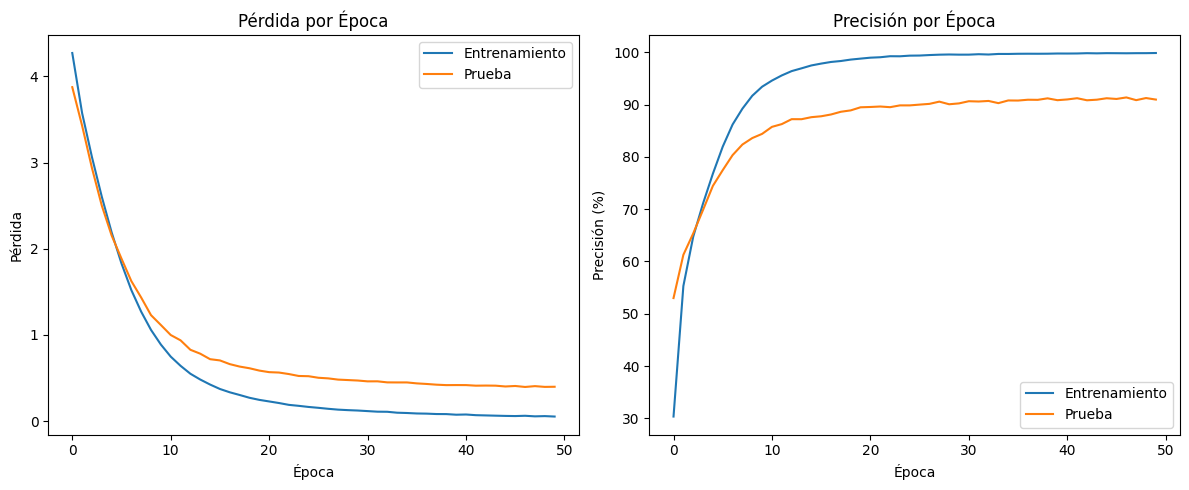

Modelo guardado como 'modelo_frutas_final.pth'


Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:36<00:00, 24.52it/s]



--- Resultado Final en Test ---
  P√©rdida: 0.3998
  Precisi√≥n: 90.97%
porcentaje de error: 9.03%


In [48]:
    
perdidas_entrenamiento = []
precisiones_entrenamiento = []
perdidas_prueba = []
precisiones_prueba = []
epocas = 50  # N√∫mero de √©pocas
for epoca in range(epocas):
    torch.cuda.empty_cache()  # Limpia memoria antes de cada √©poca
    print(f"VRAM usada: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    #verificar_temperatura()  # Verificar temperatura antes de cada √©poca
    print(f"\n√âpoca {epoca + 1}/{epocas}")
    
    # Entrenamiento
    perdida_ent, precision_ent, train_error = entrenar_epoca(
        model, train_loader, optimizer, criterion, device
    )
    
    perdidas_entrenamiento.append(perdida_ent)
    precisiones_entrenamiento.append(precision_ent)

    # 2. Evaluaci√≥n en Test (opcional: cada X √©pocas para ahorrar tiempo)
    if (epoca + 1) % 1 == 0:  # Eval√∫a cada √©poca
        perdida_test, precision_test, test_error = evaluar(
            model, test_loader, criterion, device
        )
        perdidas_prueba.append(perdida_test)
        precisiones_prueba.append(precision_test)

    # 3. Mostrar resumen
    print(f"\nResumen √âpoca {epoca + 1}:")
    print(f"  P√©rdida: Train = {perdida_ent:.4f} | Test = {perdida_test:.4f}")
    print(f"  Precisi√≥n: Train = {precision_ent:.2f}% | Test = {precision_test:.2f}%")
    print(f"  Error: entrenamiento: {train_error:.4f}% | error test: {test_error:.4f}%")
    print("-" * 50)

    # 4. Verificar condici√≥n de parada temprana
    #if precision_test >= 90 and test_error <= 5:
   #     print(f"‚úÖ Criterios alcanzados: Precisi√≥n test {precision_test:.2f}% y error test {test_error:.2f}%")
  #      print("üõë Deteniendo entrenamiento.")
 #       break  # Salir del bucle de entrenamiento
#scheduler.step(perdida_test)



graficar_resultados(
    perdidas_entrenamiento, precisiones_entrenamiento,
    perdidas_prueba, precisiones_prueba
)

torch.save(model.state_dict(), "modelo_frutas_final.pth")
print("Modelo guardado como 'modelo_frutas_final.pth'")

perdida_final, precision_final, error = evaluar(model, test_loader, criterion, device)
print(f"\n--- Resultado Final en Test ---")
print(f"  P√©rdida: {perdida_final:.4f}")
print(f"  Precisi√≥n: {precision_final:.2f}%")
print(f"porcentaje de error: {error:.2f}%")

# Graficar resultados

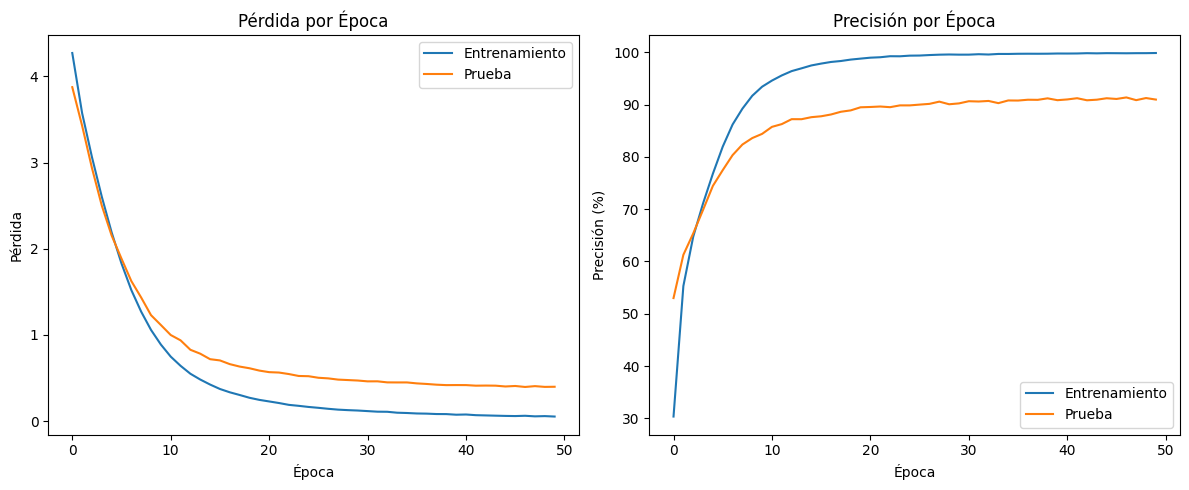

In [49]:
graficar_resultados(
    perdidas_entrenamiento, precisiones_entrenamiento,
    perdidas_prueba, precisiones_prueba
)

# Guardar modelo

In [50]:
torch.save(model.state_dict(), "modelo_frutas_final.pth")
print("Modelo guardado como 'modelo_frutas_final.pth'")

Modelo guardado como 'modelo_frutas_final.pth'


# Evaluaci√≥n FINAL en Test

In [51]:
perdida_final, precision_final, error = evaluar(model, test_loader, criterion, device)
print(f"\n--- Resultado Final en Test ---")
print(f"  P√©rdida: {perdida_final:.4f}")
print(f"  Precisi√≥n: {precision_final:.2f}%")
print(f"porcentaje de error: {error:.2f}%")

Prueba: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 902/902 [00:37<00:00, 24.12it/s]


--- Resultado Final en Test ---
  P√©rdida: 0.3998
  Precisi√≥n: 90.97%
porcentaje de error: 9.03%


In [52]:
# creamos las etiquetas
etiquetas = train_dataset.classes  # Etiquetas de las clases
print("Etiquetas:", etiquetas)

Etiquetas: ['Apple 10', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 19', 'Apple 6', 'Apple 9', 'Apple Braeburn 1', 'Apple Core 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple Rotten 1', 'Apple hit 1', 'Apple worm 1', 'Apricot 1', 'Avocado 1', 'Avocado ripe 1', 'Banana 1', 'Banana 3', 'Banana Lady Finger 1', 'Banana Red 1', 'Beans 1', 'Beetroot 1', 'Blackberrie 1', 'Blackberrie 2', 'Blackberrie half rippen 1', 'Blackberrie not rippen 1', 'Blueberry 1', 'Cabbage red 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cactus fruit green 1', 'Cactus fruit red 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 'Cauliflower 1', 'Cherimoya 1', 'Cherry 1', 'Cherry 2', 'Cherry Rainier 1', 'Cherry Wax Black 1', 'Cherry Wax Red 1', 'Cherry Wax Yellow 1', 'Cherry Wax not rippen 1', 'Chest

# cargar y probar el modelo con una imagen cualquiera
1Ô∏è‚É£ Cargar el modelo entrenado

In [53]:
# Cargar el modelo
modelo_cargado = FruitMLP() # Crear una nueva instancia del modelo
modelo_cargado.load_state_dict(torch.load("modelo_frutas_final.pth")) # Cargar los pesos
modelo_cargado.eval()  # Poner en modo evaluaci√≥n

modelo_cargado.to(device)  # Mover el modelo al mismo dispositivo que la imagen


FruitMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=30000, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=512, out_features=128, bias=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=169, bias=True)
  )
)

2Ô∏è‚É£ Cargar una imagen de prueba
Usaremos PIL y torchvision para cargar y preprocesar la imagen.

In [54]:
from PIL import Image
import torchvision.transforms as transforms

# Transformaciones para la imagen (ajustar seg√∫n tu modelo)
transformaciones = transforms.Compose([
    transforms.Resize((100, 100)),  # Ajustar tama√±o
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean= Media, std= Std)  # Normalizar
])

# Cargar imagen Apple hit 1
imagen = Image.open("C:/Users/OMEN/Downloads/26_100.jpg")  # Reemplaza con tu imagen
# imagen = Image.open("./Avocado 1.jpg")  # Reemplaza con tu imagen
imagen_mostrar = imagen
imagen = transformaciones(imagen)
imagen = imagen.unsqueeze(0)  # Agregar dimensi√≥n batch
imagen = imagen.to(device)  # Mover a GPU/CPU

3Ô∏è‚É£ Realizar la predicci√≥n

La imagen fue clasificada como la clase: Cherry 2


(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

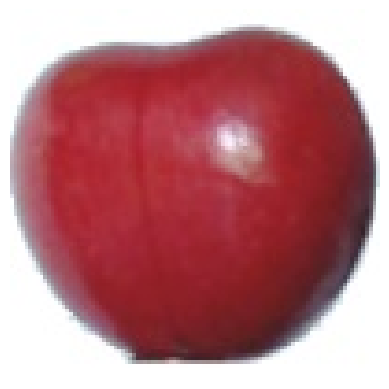

In [56]:
with torch.no_grad():  # Desactivar gradientes para inferencia
    salida = modelo_cargado(imagen)
    prediccion = torch.argmax(salida, dim=1).item()  # Obtener la clase con mayor probabilidad

print(f"La imagen fue clasificada como la clase: {etiquetas[prediccion]}")

# mostrar la imagen de estudio
plt.imshow(imagen_mostrar)
plt.axis('off')

La imagen fue clasificada como la clase: Cherry 2


(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

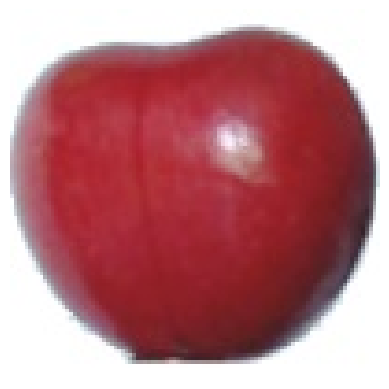

In [ ]:
with torch.no_grad():  # Desactivar gradientes para inferencia
    salida = modelo_cargado(imagen)
    prediccion = torch.argmax(salida, dim=1).item()  # Obtener la clase con mayor probabilidad

print(f"La imagen fue clasificada como la clase: {etiquetas[prediccion]}")

# mostrar la imagen de estudio
plt.imshow(imagen_mostrar)
plt.axis('off')